### Imports and Options

#### Imports

In [78]:
%reload_ext autoreload
%autoreload 1
import duckdb
import pandas as pd
from IPython.display import Markdown, display
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import functions.display_functions as disf
import functions.data_format_functions as dff
from functions.project_functions_classes import Team, MatchPlayers
from mplsoccer import Pitch
import statsmodels.api as sm
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

%aimport functions.display_functions, functions.data_format_functions, functions.project_functions_classes

#### Options

In [2]:
pd.set_option('mode.chained_assignment', None)
sns.set()
base_fig_width = 8
base_fig_height = 4.5
alpha=0.95
significance=1-alpha

In [3]:
con = duckdb.connect()
con.execute(f"INSTALL sqlite")
con.execute(f"LOAD sqlite")
con.execute(f"SET GLOBAL sqlite_all_varchar=true")
con.execute(f"CALL sqlite_attach('data/database.sqlite')")

In [4]:
tables=con.query(
            f"""--sql
SELECT table_name as 'Table Name', COUNT(column_name) AS 'Column Count' FROM information_schema.columns GROUP BY table_name
"""
        ).to_df()

In [5]:
table_columns = con.query(
    f"""--sql
SELECT table_name,
    GROUP_CONCAT(column_name) AS column_names
FROM information_schema.columns
GROUP BY table_name"""
).to_df()
tables['column_names']=table_columns['column_names'].apply(lambda x: x.split(','))

In [6]:
row_counts={}
for table_name in tables['Table Name']:
    row_counts[table_name]=con.query(f"""--sql
                                     SELECT COUNT(*) FROM {table_name}
                                     """).fetchone()[0]
    

tables=tables.join(pd.Series(row_counts).rename('Row Count'), on='Table Name')

### Match

#### Preparing Match data

In [7]:
match_cols = tables.loc[tables["Table Name"] == "Match", "column_names"].to_list()[0]
match_cols_to_remove = ["league_id","stage","match_api_id","cross"]
match_cols = [col for col in match_cols if col not in match_cols_to_remove]
match_raw = con.query(f"""--sql
          SELECT {', '.join(match_cols)} FROM Match
          """).to_df()

#### What countries were the matches played in?

##### Fetching country ids:

In [8]:
country=con.query("""--sql
SELECT * FROM Country""").to_df().set_index('id')
country=country.to_dict()['name']

##### Plotting:

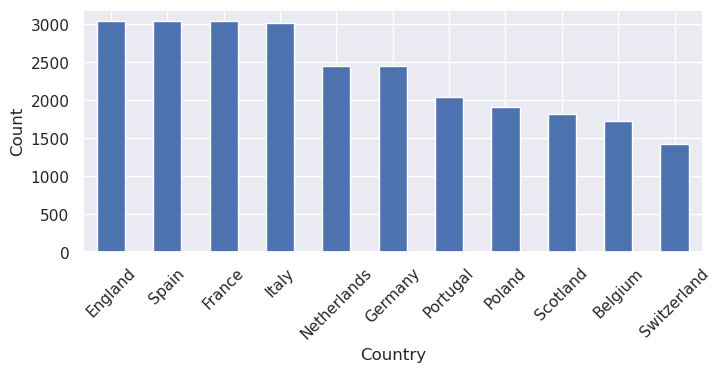

In [9]:
fig_match_country, ax_match_country = plt.subplots(
    figsize=(base_fig_width, 0.7*base_fig_height)
)
match_raw.value_counts("country_id").rename(country).plot.bar(ax=ax_match_country)
ax_match_country.set_xlabel('Country')
ax_match_country.set_ylabel('Count')
ax_match_country.tick_params(axis='x', rotation=45)
plt.show()

#### Whats the match distribution by date and season?

##### Preparing the season and date data:

In [10]:
match_raw["date"] = pd.to_datetime(match_raw["date"])
match_date_count = match_raw[["date", "id"]].resample("D", on="date").count().cumsum()

seasons=match_raw.groupby('season').agg(start=('date', 'min'),end=('date','max'),count=('season','count'))
seasons['length']=seasons['end']-seasons['start']


##### Plot:

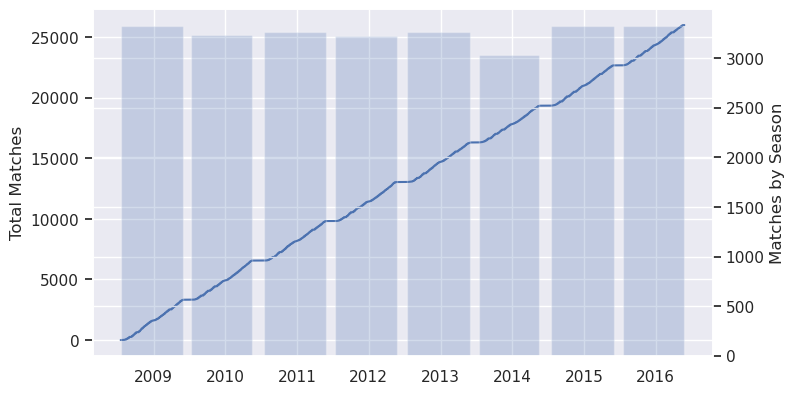

In [11]:
fig_match_count_date, ax_match_count_date = plt.subplots(
    figsize=(base_fig_width, base_fig_height)
)

ax_match_count_date.plot(match_date_count.index, match_date_count["id"])
ax_match_count_date_season = ax_match_count_date.twinx()
ax_match_count_date_season.bar(
    x=seasons["start"],
    height=seasons["count"],
    width=seasons["length"],
    align="edge",
    alpha=0.25,
)
ax_match_count_date.set_ylabel("Total Matches")
ax_match_count_date_season.set_ylabel("Matches by Season")

plt.show()

#### What is the distribution of goal difference between home and away teams?

##### Calculating the goal difference for each mach:

In [12]:
match_raw[["home_team_goal", "away_team_goal"]] = match_raw[
    ["home_team_goal", "away_team_goal"]
].astype(int)
match_raw["outcome"] = match_raw["home_team_goal"] - match_raw["away_team_goal"]
match_outcomes = match_raw["outcome"].value_counts().to_frame("count")
match_outcomes.reset_index(names=["value"], inplace=True)
match_outcomes["outcome"] = match_outcomes["value"].apply(
    lambda x: "Home Win" if x > 0 else ("Home Loss" if x < 0 else "Tie")
)
match_outcomes["color"] = match_outcomes["value"].apply(
    lambda x: sns.color_palette()[0]
    if x > 0
    else (sns.color_palette()[3] if x < 0 else sns.color_palette()[4])
)

##### Plot:

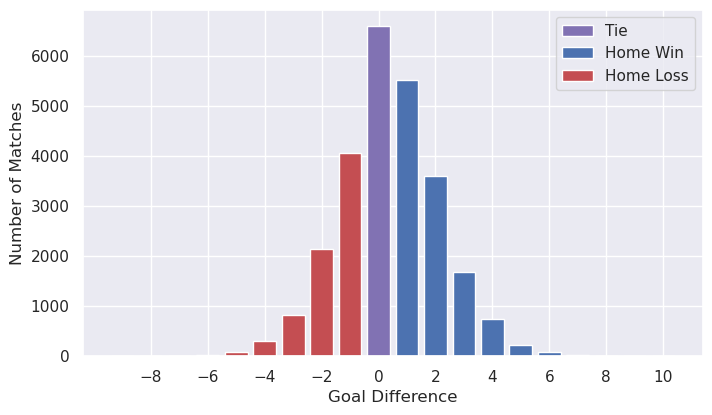

In [13]:
fig_match_outcomes,ax_match_outcomes=plt.subplots(figsize=(base_fig_width,base_fig_height))
ax_match_outcomes.bar(match_outcomes['value'],match_outcomes['count'],label=match_outcomes['outcome'],color=match_outcomes['color'],align='center')
handles, labels = ax_match_outcomes.get_legend_handles_labels()
ax_match_outcomes.legend(handles[:3],labels[:3])
ax_match_outcomes.set(xticks=np.arange(start=-8,stop=12,step=2))
ax_match_outcomes.set_ylabel('Number of Matches')
ax_match_outcomes.set_xlabel('Goal Difference')
plt.show()

#### Is there a home advantage?

##### Chi square test of non-tie matches with the null hypothesis being that there is an equal amount of home wins and away wins:

In [14]:
total_home_wins = match_outcomes.loc[match_outcomes['outcome'] == 'Home Win', 'count'].sum()
total_away_wins = match_outcomes.loc[match_outcomes['outcome'] == 'Home Loss', 'count'].sum()
home_advantage_result=stats.chisquare([total_home_wins,total_away_wins])

##### Results:

In [15]:
Markdown(f"""
Based on a chi-square test with a confidence level of 95%, the p-value of {home_advantage_result.pvalue:.2e}
strongly suggests that there is a significant home advantage.
{total_home_wins} of all non-tie wins were by the home team,
while only {total_away_wins} matches were won by away teams.
""")


Based on a chi-square test with a confidence level of 95%, the p-value of 2.82e-224
strongly suggests that there is a significant home advantage.
11917 of all non-tie wins were by the home team,
while only 7466 matches were won by away teams.


#### What are the different player combinations used?

##### Preparing player position combination columns:

In [16]:
# Getting lists of position column names
home_x_cols=[x for x in match_raw.columns.to_list() if 'home_player_X' in x]
home_y_cols=[x for x in match_raw.columns.to_list() if 'home_player_Y' in x]
away_x_cols=[x for x in match_raw.columns.to_list() if 'away_player_X' in x]
away_y_cols=[x for x in match_raw.columns.to_list() if 'away_player_Y' in x]

# Changing  the data type to numeric
match_raw[home_x_cols + home_y_cols + away_x_cols + away_y_cols] = match_raw[
    home_x_cols + home_y_cols + away_x_cols + away_y_cols
].apply(pd.to_numeric)

# Putting the home player coordinates into frozensets of (x,y) tuples
match_raw["combinations_home"] = match_raw.apply(
    lambda row: frozenset([(x, y) for x, y in zip(row[home_x_cols], row[home_y_cols])]),
    axis=1,
)

# Changing any values that contain at least a single NaN value to Nan
match_raw["combinations_home"] = match_raw["combinations_home"].apply(
    lambda x: np.nan if any(np.isnan(y) for tup in x for y in tup) else x
)

# Removing frozensets with less than 11 player coordinates
match_raw["combinations_home"] = match_raw["combinations_home"].apply(
    lambda x: x if type(x) == frozenset and len(x) == 11 else np.nan
)

# Putting the away player coordinates into frozensets of (x,y) tuples
match_raw["combinations_away"] = match_raw.apply(
    lambda row: frozenset([(x, y) for x, y in zip(row[away_x_cols], row[away_y_cols])]),
    axis=1,
)

# Removing frozensets with less than 11 player coordinates
match_raw["combinations_away"] = match_raw["combinations_away"].apply(
    lambda x: np.nan if any(np.isnan(y) for tup in x for y in tup) else x
)

# Putting the away player coordinates into frozensets of (x,y) tuples
match_raw["combinations_away"] = match_raw["combinations_away"].apply(
    lambda x: x if type(x) == frozenset and len(x) == 11 else np.nan
)

##### Number of different 11 player combinations:

In [17]:
unique_combos = pd.concat(
    [match_raw["combinations_home"], match_raw["combinations_away"]]
).value_counts().to_frame(name='count').reset_index(names=['combo'])
len(unique_combos)


37

##### Combination distribution on the pitch:

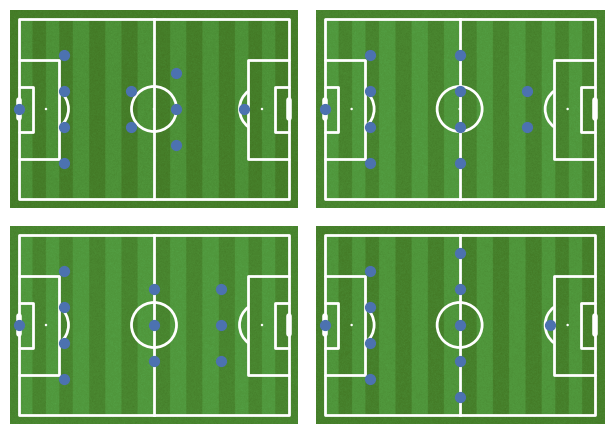

In [18]:
# Correcting the position of the goal keeper
unique_combos["scaled_combo"] = unique_combos["combo"].apply(
    lambda x: frozenset((5, 1) if t == (1, 1) else t for t in x)
)

# Scaling to the pitch plot
pitch_y_offset = 4 - dff.scale_num(1, 1, 11, -4, 80)
unique_combos["scaled_combo"] = unique_combos["scaled_combo"].apply(
    lambda x: frozenset(
        (
            dff.scale_num(t[0], 1, 11, 0, 80) + pitch_y_offset,
            dff.scale_num(t[1], 1, 11, 0, 100),
        )
        for t in x
    )
)

pitch = Pitch(
    pitch_color="grass", line_color="white", stripe=True,
    )

fig_pitch, ax_pitch = pitch.draw(nrows=2, ncols=2, figsize=(base_fig_width, base_fig_height))
ax_pitch=ax_pitch.flatten()

for i, combo in enumerate(unique_combos[:4].iterrows()):
    for pos in combo[1]["scaled_combo"]:
        ax_pitch[i].scatter(
            pos[1],
            pos[0],
            s=50,
            color=sns.color_palette("deep")[0],
        )
plt.tight_layout(w_pad=-6)
plt.show()

### Player attributes

#### What is the player rating and potential distribution?

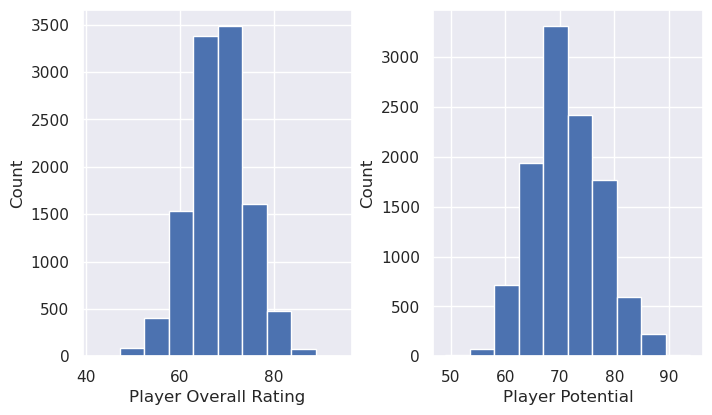

In [19]:
# Latest date

rating_potential = con.query(
    """--sql
SELECT overall_rating,
    potential
FROM Player_Attributes p
    JOIN(
        SELECT player_api_id,
            MAX(date) AS max_date
        FROM Player_attributes
        GROUP BY player_api_id
    ) sub ON p.player_api_id = sub.player_api_id
    AND p.date = sub.max_date """
).to_df()
rating_potential.dropna(inplace=True)
rating_potential = rating_potential.astype(int)

fig_player_rating_hist, (
    ax_player_rating_hist,
    ax_player_potential_hist,
) = plt.subplots(1, 2, figsize=(base_fig_width, base_fig_height))

rating_potential.hist('potential',ax=ax_player_potential_hist)
rating_potential.hist('overall_rating',ax=ax_player_rating_hist)
disf.axis_titles(ax_player_potential_hist,xtitle='Player Potential',ytitle='Count')
disf.axis_titles(ax_player_rating_hist,xtitle='Player Overall Rating',ytitle='Count')
plt.show()

#### Whats is the foot preference distribution?

In [20]:
con.query(
f"""--sql
SELECT 
    COUNT(*) AS total,
    SUM(CASE WHEN preferred_foot = 'right' THEN 1 ELSE 0 END) AS right_count,
    SUM(CASE WHEN preferred_foot = 'left' THEN 1 ELSE 0 END) AS left_count
FROM Player_Attributes p
    JOIN(
        SELECT player_api_id,
            MAX(date) AS max_date
        FROM Player_attributes
        GROUP BY player_api_id
    ) sub ON p.player_api_id = sub.player_api_id
    AND p.date = sub.max_date"""
).to_df().astype(int)

,total,right_count,left_count
0,11064,8373,2687


#### Do right and left footed players have a different overall rating?

##### Fetching the data:

In [21]:
player_f_rating=con.query(
f"""--sql
SELECT  CAST(overall_rating as INT) AS 'Overall Rating', preferred_foot
FROM Player_Attributes p
    JOIN(
        SELECT player_api_id,
            MAX(date) AS max_date
        FROM Player_attributes
        GROUP BY player_api_id
    ) sub ON p.player_api_id = sub.player_api_id
    AND p.date = sub.max_date"""
).to_df()

##### T-test:

In [22]:
player_f_rating_levresults = stats.levene(
    player_f_rating.loc[player_f_rating["preferred_foot"] == "right", "Overall Rating"],
    player_f_rating.loc[player_f_rating["preferred_foot"] == "left", "Overall Rating"],
)

player_f_rating_tresults = stats.ttest_ind(
    player_f_rating.loc[player_f_rating["preferred_foot"] == "right", "Overall Rating"],
    player_f_rating.loc[player_f_rating["preferred_foot"] == "left", "Overall Rating"],
    equal_var=player_f_rating_levresults.pvalue > significance,
)
Markdown(
    f"""t-statistic: {round(player_f_rating_tresults.statistic,2)}<br>
         p-val: {round(player_f_rating_tresults.pvalue,2)}<br>
         There {'is a' if player_f_rating_tresults.pvalue < significance else 'is no'} 
         significant difference in overall rating between right and left footed players
         """
)

t-statistic: -0.54<br>
         p-val: 0.59<br>
         There is no 
         significant difference in overall rating between right and left footed players
         

#### What is the distribution of goal keeper statistics?

##### Getting the histogram data for goal keeper diving ability:

In [23]:
goaly_hist_df=con.query(
f"""--sql
WITH bin_stats AS (
    SELECT (
            (
                MAX(CAST(gk_diving AS INT)) - MIN(CAST(gk_diving AS INT))
            ) / 10
        ) AS bin_size
    FROM Player_Attributes p
        JOIN(
            SELECT player_api_id,
                MAX(date) AS max_date
            FROM Player_attributes
            GROUP BY player_api_id
        ) sub ON p.player_api_id = sub.player_api_id
        AND p.date = sub.max_date
)
SELECT FLOOR(
        CAST(gk_diving AS INT) / (
            SELECT bin_size
            FROM bin_stats
        )
    ) * (
        SELECT bin_size
        FROM bin_stats
    ) AS bin,
    COUNT(*) AS count
FROM Player_Attributes p
    JOIN(
        SELECT player_api_id,
            MAX(date) AS max_date
        FROM Player_attributes
        GROUP BY player_api_id
    ) sub ON p.player_api_id = sub.player_api_id
    AND p.date = sub.max_date
GROUP BY bin
ORDER BY bin;
    """
).to_df().astype(int,errors='ignore')

##### Plotting the frequencies:

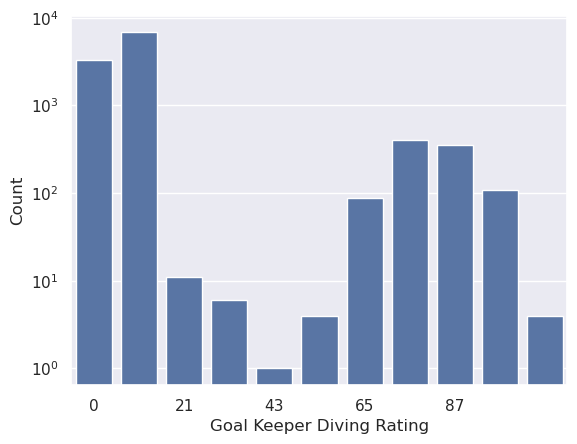

In [24]:
fig_goaly_stats, ax_goaly_stats = plt.subplots()
sns.barplot(goaly_hist_df, x="bin", y="count", ax=ax_goaly_stats, color=sns.color_palette()[0])
ax_goaly_stats.set_xticks(np.arange(0, 10, step=2))
ax_goaly_stats.set_xticklabels(
    np.linspace(goaly_hist_df["bin"].min(), goaly_hist_df["bin"].max(), num=5).astype(
        int
    )
)
ax_goaly_stats.set_yscale('log')
disf.axis_titles(ax=ax_goaly_stats, ytitle='Count', xtitle='Goal Keeper Diving Rating')
plt.show()

#### Whats the distribution of attacking and defensive work?

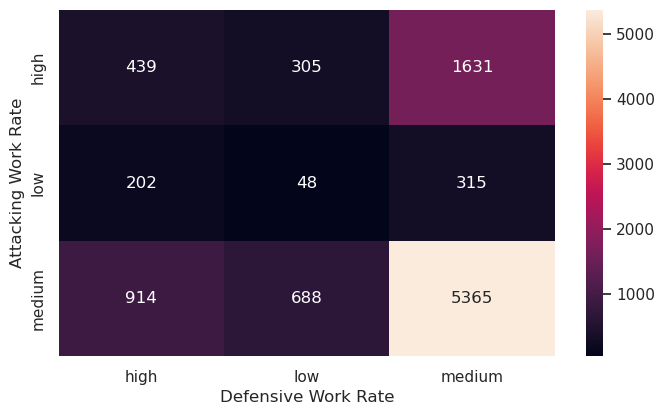

In [25]:
att_def_df = con.query(
    f"""--sql
SELECT attacking_work_rate, defensive_work_rate
FROM Player_Attributes p
    JOIN(
        SELECT player_api_id,
            MAX(date) AS max_date
        FROM Player_attributes
        GROUP BY player_api_id
    ) sub ON p.player_api_id = sub.player_api_id
    AND p.date = sub.max_date"""
).to_df()

fig_att_def, ax_att_def = plt.subplots(figsize=(base_fig_width, base_fig_height))
sns.heatmap(
    pd.crosstab(att_def_df["attacking_work_rate"], att_def_df["defensive_work_rate"])[
        ["high", "low", "medium"]
    ].loc[["high", "low", "medium"]],
    annot=True,
    fmt='.0f',
    ax=ax_att_def
)
disf.axis_titles(ax=ax_att_def,xtitle='Defensive Work Rate',ytitle='Attacking Work Rate')

### Teams

##### Getting the team attributes:

In [26]:
team_attr_raw = con.query(
f"""--sql
SELECT *
FROM Team_Attributes
"""
).to_df()

#### What is the distribution of Team attributes?

##### Making a list of numeric attributes and fixing data types:

In [27]:
team_numeric_cols = [
    "buildUpPlaySpeed",
    "buildUpPlayDribbling",
    "buildUpPlayPassing",
    "chanceCreationPassing",
    "chanceCreationCrossing",
    "chanceCreationShooting",
    "defencePressure",
    "defenceAggression",
    "defenceTeamWidth",
]
team_categoric_cols = [col + "Class" for col in team_numeric_cols]
team_attr_raw[team_numeric_cols] = team_attr_raw[team_numeric_cols].apply(
    pd.to_numeric, errors="coerce"
)
team_attr_raw['date']=pd.to_datetime(team_attr_raw['date'])
team_attr_raw.set_index('id',inplace=True)

latest_team_attr=team_attr_raw.loc[team_attr_raw.groupby('team_api_id').date.idxmax()]

##### Plotting numeric attributes and their categories:

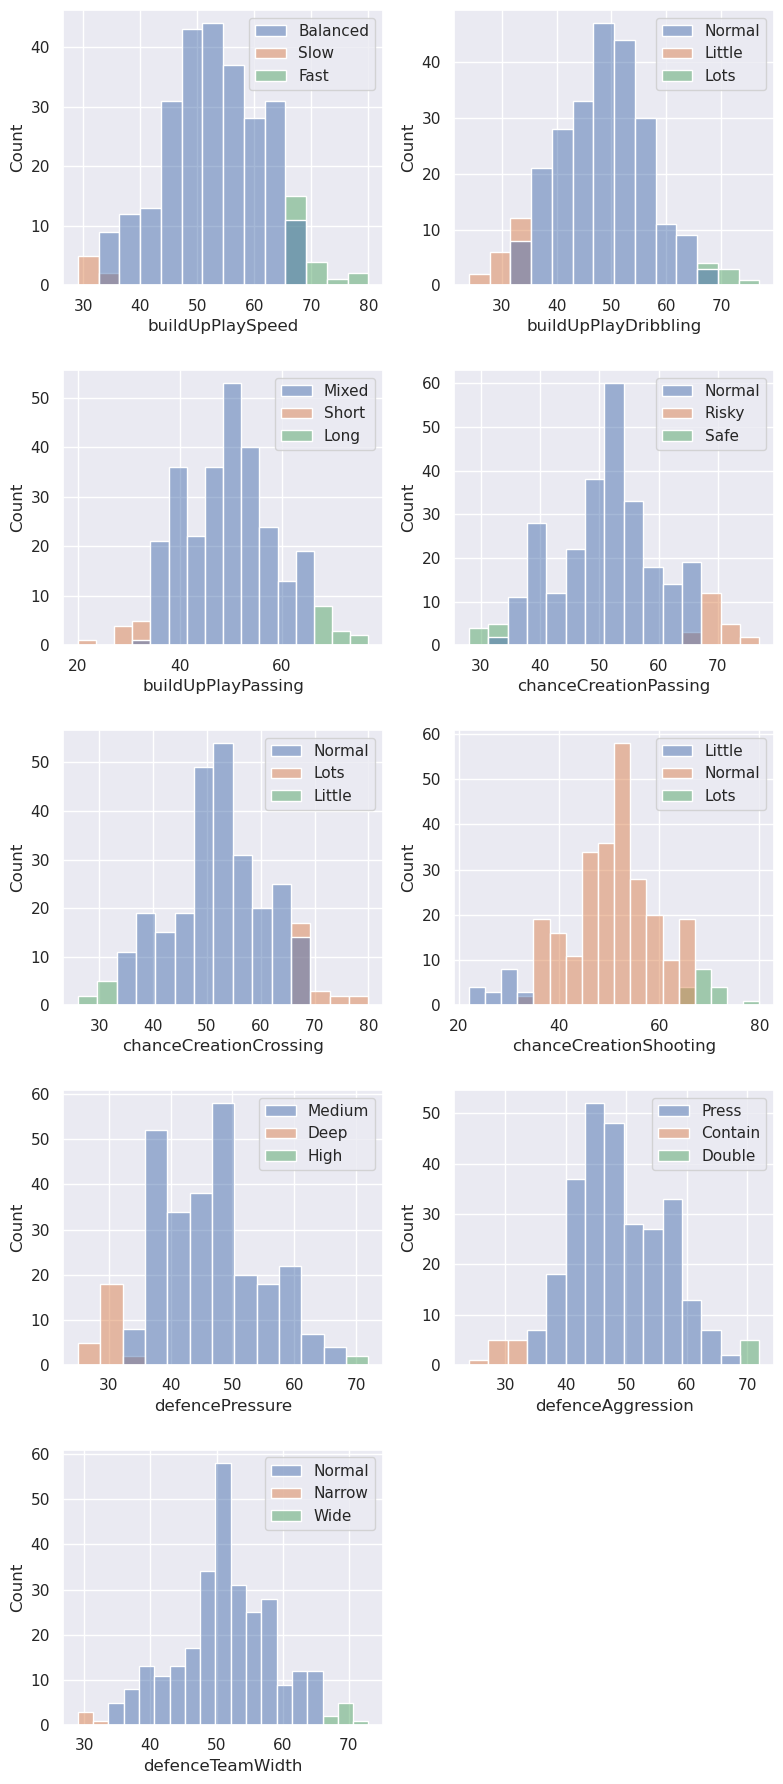

In [28]:
fig_team_attr,ax_team_attr=plt.subplots(5,2,figsize=(base_fig_width,base_fig_height*4))
ax_team_attr=ax_team_attr.flatten()
for i, attr in enumerate(team_numeric_cols):
    sns.histplot(latest_team_attr,x=attr, hue=attr+'Class',ax=ax_team_attr[i])
    ax_team_attr[i].get_legend().set_title("")

fig_team_attr.delaxes(ax_team_attr[-1])
plt.tight_layout(h_pad=2)
plt.show()

##### Plotting non numeric attributes:

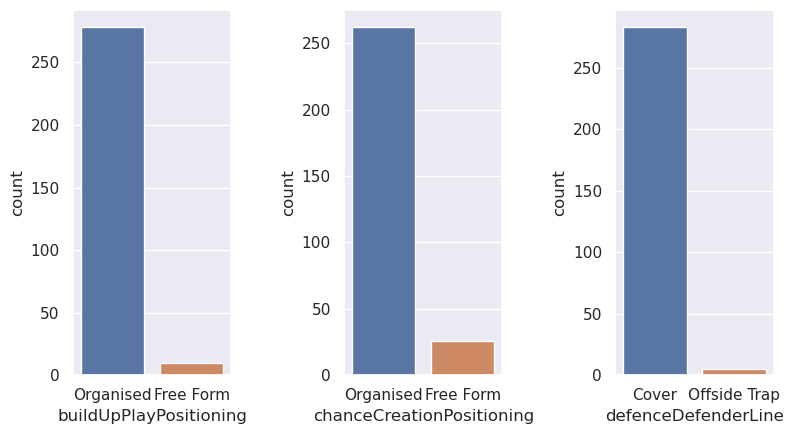

In [29]:
team_attr_non_numeric = [
    "buildUpPlayPositioningClass",
    "chanceCreationPositioningClass",
    "defenceDefenderLineClass",
]

fig_team_attr_cat, ax_team_attr_cat = plt.subplots(
    1, 3, figsize=(base_fig_width, base_fig_height)
)
ax_team_attr_cat = ax_team_attr_cat.flatten()

for i, attr in enumerate(team_attr_non_numeric):
    sns.countplot(data=latest_team_attr, x=attr, ax=ax_team_attr_cat[i])
    ax_team_attr_cat[i].set_xlabel(attr[:-5])
plt.tight_layout(w_pad=3)
plt.show()

#### Do the numeric team attributes correlate linearly with each other?

In [30]:
disf.get_correlation_pairs(latest_team_attr,0.3,-0.3)

,r-value,feature_pair
0,0.327754,"(chanceCreationPassing, buildUpPlaySpeed)"
2,0.466181,"(defenceAggression, defencePressure)"
3,0.363279,"(defenceTeamWidth, defencePressure)"


Certain defensive attribute seem to have a moderate linear correlation with each other, as well as build up play speed and chance creation passing attributes.

## Feature selection

In [31]:
match_win_df = match_raw[
    [
        "country_id",
        "date",
        "home_team_api_id",
        "away_team_api_id",
        "home_team_goal",
        "away_team_goal",
    ]
]


match_win_df["home_team_win"] = match_win_df.apply(
    lambda x: 1 if x["home_team_goal"] > x["away_team_goal"] else 0, axis=1
)

In [32]:
match_win_df["home_team_win"].value_counts()

0    14062
1    11917
Name: home_team_win, dtype: int64

#### Do combinations influence the match outcome?

##### Adding the combination data:

In [33]:
# Number labels for unique combinations
combo_dict = unique_combos["combo"].to_dict()
combo_dict = {v: k for k, v in combo_dict.items()}

# Adding the combinations from the raw data
match_win_df = pd.merge(
    match_win_df,
    match_raw[["combinations_home", "combinations_away"]],
    left_index=True,
    right_index=True,
)

# Changing the combinations into a single number label
match_win_df[["combinations_home", "combinations_away"]] = match_win_df[
    ["combinations_home", "combinations_away"]
].replace(combo_dict)

# Making a column with the home away combination pairs
match_win_df["combo_home_away"] = match_win_df.apply(
    lambda x: (x["combinations_home"], x["combinations_away"]), axis=1
)
match_win_df['combo_home_away']=match_win_df['combo_home_away'].apply(lambda x: np.nan if np.isnan(x).any() else x)

##### Chi-squared test with the null hypothesis that home team combination is not associated to home the home team winning:

In [34]:
comb_h_home_w_con_tab = pd.crosstab(
    match_win_df.loc[match_win_df["combinations_home"] <= 5, "home_team_win"],
    match_win_df.loc[match_win_df["combinations_home"] <= 5, "combinations_home"],
)
comb_h_home_w_results = stats.chi2_contingency(comb_h_home_w_con_tab)
Markdown(
    f"""Chi-squared statistic: {round(comb_h_home_w_results.statistic,1)}<br>
         p-val: {comb_h_home_w_results.pvalue:.2e}<br>
         The home team combination {'is' if comb_h_home_w_results.pvalue<significance else 'is not'} 
         significantly associated with the home team winning.
         """
)

Chi-squared statistic: 50.8<br>
         p-val: 9.40e-10<br>
         The home team combination is 
         significantly associated with the home team winning.
         

##### Chi-squared test with the null hypothesis that away team combination is not associated to home the home team winning:

In [35]:
comb_a_home_w_con_tab = pd.crosstab(
    match_win_df.loc[match_win_df['combinations_away']<=5, "home_team_win"],
    match_win_df.loc[match_win_df["combinations_away"]<=5, "combinations_away"]
)
comb_a_home_w_results=stats.chi2_contingency(comb_a_home_w_con_tab)

Markdown(
    f"""Chi-squared statistic: {round(comb_a_home_w_results.statistic,1)}<br>
         p-val: {comb_a_home_w_results.pvalue:.2e}<br>
         The home team combination {'is' if comb_a_home_w_results.pvalue<significance else 'is not'} 
         significantly associated with the home team winning.
         """
)

Chi-squared statistic: 27.1<br>
         p-val: 5.55e-05<br>
         The home team combination is 
         significantly associated with the home team winning.
         

##### Chi-squared test with the null hypothesis that home-away team combination pair is not associated to home the home team winning:

In [36]:
comb_ha_home_w_con_tab = pd.crosstab(
    match_win_df['combo_home_away'].apply(str),
    match_win_df['home_team_win']
)
comb_ha_home_w_results=stats.chi2_contingency(comb_ha_home_w_con_tab)

Markdown(
    f"""Chi-squared statistic: {round(comb_ha_home_w_results.statistic,1)}<br>
         p-val: {comb_ha_home_w_results.pvalue:.2e}<br>
         The home-away team combination pair {'is' if comb_ha_home_w_results.pvalue<significance else 'is not'} 
         significantly associated with the home team winning.
         """
)

Chi-squared statistic: 756.2<br>
         p-val: 3.67e-05<br>
         The home-away team combination pair is 
         significantly associated with the home team winning.
         

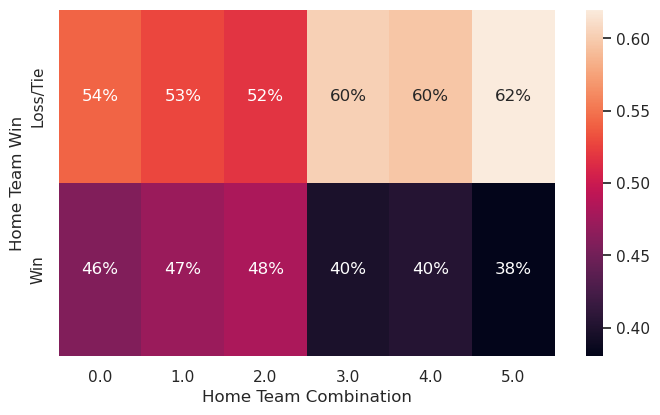

In [37]:
fig_combo_contingency, ax_combo_contingency = plt.subplots(
    figsize=(base_fig_width, base_fig_height)
)
sns.heatmap(
    comb_h_home_w_con_tab.apply(lambda x: x.div(x.sum(), axis=0)),
    fmt=".0%",
    annot=True,
    ax=ax_combo_contingency,
)
disf.axis_titles(ax=ax_combo_contingency,xtitle="Home Team Combination", ytitle="Home Team Win")
ax_combo_contingency.set_yticklabels(['Loss/Tie','Win'])
plt.show()

In [38]:
match_win_df['combinations_home'].value_counts()[10:].sum()

2920

In [39]:
match_win_df.drop(["combo_home_away", "combinations_away"], axis=1, inplace=True)

The combinations of player positions seem to matter for the game outcome, yet the number of pair combinations is possibly too high to be added as a features, therefore only home team combination will added, furthermore only the top 10 most popular combinations shall be considered, this causes a loss of 2920 values out of 24145.

### Adding Team Attributes

##### Importing team attributes into a dataframe:

In [40]:
team_attr_raw = con.query(
    """--sql
SELECT *
FROM Team_attributes
"""
).to_df()

team_attr_raw['date']=pd.to_datetime(team_attr_raw['date'])

##### Creating Team class objects for each team:

In [41]:
unique_team_ids = [
    i[0]
    for i in con.query(
        """--sql
SELECT DISTINCT team_api_id
FROM Team_attributes
"""
    ).fetchall()
]
teams={}

for team in unique_team_ids:
    teams[team]=Team(team)
    teams[team].get_data(team_attr_raw)

##### Adding the team objects to the match dataframe:

In [42]:
match_win_df["home_team"] = match_win_df["home_team_api_id"].map(teams)
match_win_df["away_team"] = match_win_df["away_team_api_id"].map(teams)
# Some teams do not have attributes, therefore, dropping matches with those teams
match_win_df.dropna(inplace=True)

##### Getting the latest team attributes by match date using the Team class:

In [43]:
team_attributes_home = {}
for index, row in match_win_df.iterrows():
    team_attributes_home[index] = row["home_team"].get_latest_entry(row["date"], team_numeric_cols)

team_attributes_away = {}
for index, row in match_win_df.iterrows():
    team_attributes_away[index] = row["away_team"].get_latest_entry(row["date"], team_numeric_cols)


match_win_df = match_win_df.join(
    pd.concat(list(team_attributes_home.values()), keys=team_attributes_home.keys()).droplevel(1), rsuffix='_home'
)

match_win_df = match_win_df.join(
    pd.concat(list(team_attributes_away.values()), keys=team_attributes_away.keys()).droplevel(1), rsuffix='_away'
)

##### Dropping matches where teams do not have date relevant attributes:

In [44]:
match_win_df.dropna(inplace=True)

##### Fixing the data types of numeric features:

In [45]:
cols_to_drop = [
    "date",
    "country_id",
    "home_team_api_id",
    "away_team_api_id",
    "home_team_goal",
    "away_team_goal",
    "combinations_home",
    "home_team",
    "away_team",
    "home_team_win",
]
match_win_df[match_win_df.drop(columns=cols_to_drop).columns] = match_win_df[
    match_win_df.drop(columns=cols_to_drop).columns
].astype(int)

##### Logistic regression with all home and away team attributes:

In [48]:
home_win_target = match_win_df["home_team_win"]
home_win_team_features = match_win_df.drop(columns=cols_to_drop)

# Scaling the data
team_feat_scaler = StandardScaler()
home_win_team_features = team_feat_scaler.fit_transform(home_win_team_features)

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    home_win_team_features, home_win_target, test_size=0.33, random_state=1
)

# Create and fit the logistic regression model
logit_model = sm.Logit(y_train, sm.add_constant(X_train))
result = logit_model.fit()

# Print the summary of the model
print(result.summary())

# Predict using the trained model
predictions = result.predict(sm.add_constant(X_test))

# Print the predicted probabilities
print(classification_report(y_test, predictions.round()))

Optimization terminated successfully.
         Current function value: 0.670147
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:          home_team_win   No. Observations:                 3726
Model:                          Logit   Df Residuals:                     3707
Method:                           MLE   Df Model:                           18
Date:                Mon, 10 Jul 2023   Pseudo R-squ.:                 0.02413
Time:                        10:08:09   Log-Likelihood:                -2497.0
converged:                       True   LL-Null:                       -2558.7
Covariance Type:            nonrobust   LLR p-value:                 9.150e-18
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2390      0.034     -7.114      0.000      -0.305      -0.173
x1            -0.0761      0.

##### Logistic regression with home-away team attribute differences:

In [56]:
home_win_team_features = match_win_df.drop(columns=cols_to_drop)
home_win_team_features = (
    home_win_team_features[team_numeric_cols].values
    - home_win_team_features[[col + "_away" for col in team_numeric_cols]].values
)
team_feat_ratio_scaler = StandardScaler()
home_win_team_features = team_feat_ratio_scaler.fit_transform(home_win_team_features)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    home_win_team_features, home_win_target, test_size=0.33, random_state=1
)

# Create and fit the logistic regression model
logit_model = sm.Logit(y_train, sm.add_constant(X_train))
result = logit_model.fit()

# Print the summary of the model
print(result.summary())

# Predict using the trained model
predictions = result.predict(sm.add_constant(X_test))

# Print the classification report
print(classification_report(y_test, predictions.round()))

Optimization terminated successfully.
         Current function value: 0.672126
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:          home_team_win   No. Observations:                 3726
Model:                          Logit   Df Residuals:                     3716
Method:                           MLE   Df Model:                            9
Date:                Mon, 10 Jul 2023   Pseudo R-squ.:                 0.02125
Time:                        10:22:24   Log-Likelihood:                -2504.3
converged:                       True   LL-Null:                       -2558.7
Covariance Type:            nonrobust   LLR p-value:                 2.639e-19
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2383      0.034     -7.110      0.000      -0.304      -0.173
x1            -0.0528      0.

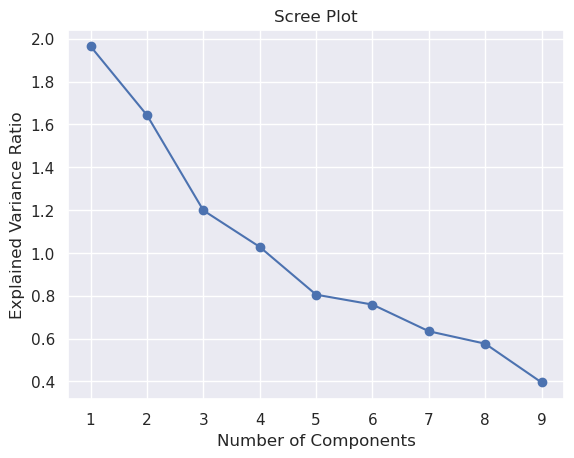

In [ ]:
# Perform PCA with different numbers of components
pca = PCA(n_components=9)
pca.fit(home_win_team_features)

# Plot the scree plot with eigenvalues
plt.plot(np.arange(pca.n_components_)+1, pca.explained_variance_, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.show()

In [59]:
pca = PCA(n_components=4)
team_principal_components = pca.fit_transform(home_win_team_features)
X_train, X_test, y_train, y_test = train_test_split(team_principal_components, home_win_target, test_size=0.33, random_state=1)

# Create and fit the logistic regression model
logit_model_team_diff_pc = sm.Logit(y_train, sm.add_constant(X_train))
result_team_diff_pc = logit_model_team_diff_pc.fit()

# Print the summary of the model
print(result_team_diff_pc.summary())

# Predict using the trained model
predictions_team_diff_pc = result_team_diff_pc.predict(sm.add_constant(X_test))

# Print the classification report
print(classification_report(y_test, predictions_team_diff_pc.round()))



Optimization terminated successfully.
         Current function value: 0.675856
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:          home_team_win   No. Observations:                 3726
Model:                          Logit   Df Residuals:                     3721
Method:                           MLE   Df Model:                            4
Date:                Mon, 10 Jul 2023   Pseudo R-squ.:                 0.01582
Time:                        10:31:06   Log-Likelihood:                -2518.2
converged:                       True   LL-Null:                       -2558.7
Covariance Type:            nonrobust   LLR p-value:                 1.092e-16
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2345      0.033     -7.028      0.000      -0.300      -0.169
x1             0.1394      0.

### Player

In [66]:
match_raw.iloc[match_win_df.index].columns

Index(['id', 'country_id', 'season', 'date', 'home_team_api_id',
       'away_team_api_id', 'home_team_goal', 'away_team_goal',
       'home_player_X1', 'home_player_X2',
       ...
       'VCA', 'GBH', 'GBD', 'GBA', 'BSH', 'BSD', 'BSA', 'outcome',
       'combinations_home', 'combinations_away'],
      dtype='object', length=114)

In [85]:
mat=MatchPlayers()
mat.get_data(match_raw.iloc[1000])

In [89]:
mat.away_player_pos

{1: (1.0, 1.0),
 2: (2.0, 3.0),
 3: (4.0, 3.0),
 4: (6.0, 3.0),
 5: (8.0, 3.0),
 6: (2.0, 7.0),
 7: (4.0, 7.0),
 8: (6.0, 7.0),
 9: (8.0, 7.0),
 10: (4.0, 10.0),
 11: (6.0, 10.0)}

In [97]:
mat.get_player_ids()

['home_player_1', 'home_player_2', 'home_player_3', 'home_player_4', 'home_player_5', 'home_player_6', 'home_player_7', 'home_player_8', 'home_player_9', 'home_player_10', 'home_player_11']
home_player_1


In [99]:
mat.home_player_ids

{'players': ['67941',
  '80184',
  '38956',
  '39389',
  '67896',
  '39145',
  '300401',
  '104410',
  '27282',
  '26612'],
 'goaly': '39573'}

In [90]:
mat.away_player_pos
next(key for key, val in mat.away_player_pos.items() if val == (2,3))

2

In [76]:
# match_raw.iloc[1000][['home_player_'+str(i) for i in np.arange(1,12)]].values
match_raw.iloc[1000].to_dict()

{'id': '1001',
 'country_id': '1',
 'season': '2012/2013',
 'date': Timestamp('2012-07-28 00:00:00'),
 'home_team_api_id': '8203',
 'away_team_api_id': '9986',
 'home_team_goal': 4,
 'away_team_goal': 2,
 'home_player_X1': 1.0,
 'home_player_X2': 2.0,
 'home_player_X3': 4.0,
 'home_player_X4': 6.0,
 'home_player_X5': 8.0,
 'home_player_X6': 5.0,
 'home_player_X7': 2.0,
 'home_player_X8': 4.0,
 'home_player_X9': 6.0,
 'home_player_X10': 8.0,
 'home_player_X11': 5.0,
 'away_player_X1': 1.0,
 'away_player_X2': 2.0,
 'away_player_X3': 4.0,
 'away_player_X4': 6.0,
 'away_player_X5': 8.0,
 'away_player_X6': 2.0,
 'away_player_X7': 4.0,
 'away_player_X8': 6.0,
 'away_player_X9': 8.0,
 'away_player_X10': 4.0,
 'away_player_X11': 6.0,
 'home_player_Y1': 1.0,
 'home_player_Y2': 3.0,
 'home_player_Y3': 3.0,
 'home_player_Y4': 3.0,
 'home_player_Y5': 3.0,
 'home_player_Y6': 6.0,
 'home_player_Y7': 8.0,
 'home_player_Y8': 8.0,
 'home_player_Y9': 8.0,
 'home_player_Y10': 8.0,
 'home_player_Y11': 11.

In [ ]:
Markdown(tabulate(con.query(
    f"""--sql
SELECT * from Team_Attributes LIMIT 5"""
).to_df(), showindex=False, headers="keys", tablefmt="pipe"))

|   id |   team_fifa_api_id |   team_api_id | date                |   buildUpPlaySpeed | buildUpPlaySpeedClass   |   buildUpPlayDribbling | buildUpPlayDribblingClass   |   buildUpPlayPassing | buildUpPlayPassingClass   | buildUpPlayPositioningClass   |   chanceCreationPassing | chanceCreationPassingClass   |   chanceCreationCrossing | chanceCreationCrossingClass   |   chanceCreationShooting | chanceCreationShootingClass   | chanceCreationPositioningClass   |   defencePressure | defencePressureClass   |   defenceAggression | defenceAggressionClass   |   defenceTeamWidth | defenceTeamWidthClass   | defenceDefenderLineClass   |
|-----:|-------------------:|--------------:|:--------------------|-------------------:|:------------------------|-----------------------:|:----------------------------|---------------------:|:--------------------------|:------------------------------|------------------------:|:-----------------------------|-------------------------:|:------------------------------|-------------------------:|:------------------------------|:---------------------------------|------------------:|:-----------------------|--------------------:|:-------------------------|-------------------:|:------------------------|:---------------------------|
|    1 |                434 |          9930 | 2010-02-22 00:00:00 |                 60 | Balanced                |                    nan | Little                      |                   50 | Mixed                     | Organised                     |                      60 | Normal                       |                       65 | Normal                        |                       55 | Normal                        | Organised                        |                50 | Medium                 |                  55 | Press                    |                 45 | Normal                  | Cover                      |
|    2 |                434 |          9930 | 2014-09-19 00:00:00 |                 52 | Balanced                |                     48 | Normal                      |                   56 | Mixed                     | Organised                     |                      54 | Normal                       |                       63 | Normal                        |                       64 | Normal                        | Organised                        |                47 | Medium                 |                  44 | Press                    |                 54 | Normal                  | Cover                      |
|    3 |                434 |          9930 | 2015-09-10 00:00:00 |                 47 | Balanced                |                     41 | Normal                      |                   54 | Mixed                     | Organised                     |                      54 | Normal                       |                       63 | Normal                        |                       64 | Normal                        | Organised                        |                47 | Medium                 |                  44 | Press                    |                 54 | Normal                  | Cover                      |
|    4 |                 77 |          8485 | 2010-02-22 00:00:00 |                 70 | Fast                    |                    nan | Little                      |                   70 | Long                      | Organised                     |                      70 | Risky                        |                       70 | Lots                          |                       70 | Lots                          | Organised                        |                60 | Medium                 |                  70 | Double                   |                 70 | Wide                    | Cover                      |
|    5 |                 77 |          8485 | 2011-02-22 00:00:00 |                 47 | Balanced                |                    nan | Little                      |                   52 | Mixed                     | Organised                     |                      53 | Normal                       |                       48 | Normal                        |                       52 | Normal                        | Organised                        |                47 | Medium                 |                  47 | Press                    |                 52 | Normal                  | Cover                      |

In [ ]:
Markdown(tabulate(con.query(
    f"""--sql
SELECT * from Match LIMIT 5"""
).to_df(), showindex=False, headers="keys", tablefmt="pipe"))

|   id |   country_id |   league_id | season    |   stage | date                |   match_api_id |   home_team_api_id |   away_team_api_id |   home_team_goal |   away_team_goal |   home_player_X1 |   home_player_X2 |   home_player_X3 |   home_player_X4 |   home_player_X5 |   home_player_X6 |   home_player_X7 |   home_player_X8 |   home_player_X9 |   home_player_X10 |   home_player_X11 |   away_player_X1 |   away_player_X2 |   away_player_X3 |   away_player_X4 |   away_player_X5 |   away_player_X6 |   away_player_X7 |   away_player_X8 |   away_player_X9 |   away_player_X10 |   away_player_X11 |   home_player_Y1 |   home_player_Y2 |   home_player_Y3 |   home_player_Y4 |   home_player_Y5 |   home_player_Y6 |   home_player_Y7 |   home_player_Y8 |   home_player_Y9 |   home_player_Y10 |   home_player_Y11 |   away_player_Y1 |   away_player_Y2 |   away_player_Y3 |   away_player_Y4 |   away_player_Y5 |   away_player_Y6 |   away_player_Y7 |   away_player_Y8 |   away_player_Y9 |   away_player_Y10 |   away_player_Y11 |   home_player_1 |   home_player_2 |   home_player_3 |   home_player_4 |   home_player_5 |   home_player_6 |   home_player_7 |   home_player_8 |   home_player_9 |   home_player_10 |   home_player_11 |   away_player_1 |   away_player_2 |   away_player_3 |   away_player_4 |   away_player_5 |   away_player_6 |   away_player_7 |   away_player_8 |   away_player_9 |   away_player_10 |   away_player_11 |   goal |   shoton |   shotoff |   foulcommit |   card |   cross |   corner |   possession |   B365H |   B365D |   B365A |   BWH |   BWD |   BWA |   IWH |   IWD |   IWA |   LBH |   LBD |   LBA |   PSH |   PSD |   PSA |   WHH |   WHD |   WHA |   SJH |   SJD |   SJA |   VCH |   VCD |   VCA |   GBH |   GBD |   GBA |   BSH |   BSD |   BSA |
|-----:|-------------:|------------:|:----------|--------:|:--------------------|---------------:|-------------------:|-------------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|------------------:|------------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|------------------:|------------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|------------------:|------------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|------------------:|------------------:|----------------:|----------------:|----------------:|----------------:|----------------:|----------------:|----------------:|----------------:|----------------:|-----------------:|-----------------:|----------------:|----------------:|----------------:|----------------:|----------------:|----------------:|----------------:|----------------:|----------------:|-----------------:|-----------------:|-------:|---------:|----------:|-------------:|-------:|--------:|---------:|-------------:|--------:|--------:|--------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|
|    1 |            1 |           1 | 2008/2009 |       1 | 2008-08-17 00:00:00 |         492473 |               9987 |               9993 |                1 |                1 |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |              nan |              nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |              nan |              nan |    nan |      nan |       nan |          nan |    nan |     nan |      nan |          nan |    1.73 |    3.4  |    5    |  1.75 |  3.35 |  4.2  |  1.85 |   3.2 |   3.5 |  1.8  |   3.3 |  3.75 |   nan |   nan |   nan |  1.7  |  3.3  |  4.33 |  1.9  |   3.3 |  4    |  1.65 |  3.4  |  4.5  |  1.78 |  3.25 |  4    |  1.73 |  3.4  |  4.2  |
|    2 |            1 |           1 | 2008/2009 |       1 | 2008-08-16 00:00:00 |         492474 |              10000 |               9994 |                0 |                0 |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |              nan |              nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |              nan |              nan |    nan |      nan |       nan |          nan |    nan |     nan |      nan |          nan |    1.95 |    3.2  |    3.6  |  1.8  |  3.3  |  3.95 |  1.9  |   3.2 |   3.5 |  1.9  |   3.2 |  3.5  |   nan |   nan |   nan |  1.83 |  3.3  |  3.6  |  1.95 |   3.3 |  3.8  |  2    |  3.25 |  3.25 |  1.85 |  3.25 |  3.75 |  1.91 |  3.25 |  3.6  |
|    3 |            1 |           1 | 2008/2009 |       1 | 2008-08-16 00:00:00 |         492475 |               9984 |               8635 |                0 |                3 |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |              nan |              nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |              nan |              nan |    nan |      nan |       nan |          nan |    nan |     nan |      nan |          nan |    2.38 |    3.3  |    2.75 |  2.4  |  3.3  |  2.55 |  2.6  |   3.1 |   2.3 |  2.5  |   3.2 |  2.5  |   nan |   nan |   nan |  2.5  |  3.25 |  2.4  |  2.63 |   3.3 |  2.5  |  2.35 |  3.25 |  2.65 |  2.5  |  3.2  |  2.5  |  2.3  |  3.2  |  2.75 |
|    4 |            1 |           1 | 2008/2009 |       1 | 2008-08-17 00:00:00 |         492476 |               9991 |               9998 |                5 |                0 |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |              nan |              nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |              nan |              nan |    nan |      nan |       nan |          nan |    nan |     nan |      nan |          nan |    1.44 |    3.75 |    7.5  |  1.4  |  4    |  6.8  |  1.4  |   3.9 |   6   |  1.44 |   3.6 |  6.5  |   nan |   nan |   nan |  1.44 |  3.75 |  6    |  1.44 |   4   |  7.5  |  1.45 |  3.75 |  6.5  |  1.5  |  3.75 |  5.5  |  1.44 |  3.75 |  6.5  |
|    5 |            1 |           1 | 2008/2009 |       1 | 2008-08-16 00:00:00 |         492477 |               7947 |               9985 |                1 |                3 |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |              nan |              nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |              nan |              nan |    nan |      nan |       nan |          nan |    nan |     nan |      nan |          nan |    5    |    3.5  |    1.65 |  5    |  3.5  |  1.6  |  4    |   3.3 |   1.7 |  4    |   3.4 |  1.72 |   nan |   nan |   nan |  4.2  |  3.4  |  1.7  |  4.5  |   3.5 |  1.73 |  4.5  |  3.4  |  1.65 |  4.5  |  3.5  |  1.65 |  4.75 |  3.3  |  1.67 |

In [ ]:
Markdown(tabulate(con.query(
    f"""--sql
SELECT * from League"""
).to_df(), showindex=False, headers="keys", tablefmt="pipe"))

|    id |   country_id | name                     |
|------:|-------------:|:-------------------------|
|     1 |            1 | Belgium Jupiler League   |
|  1729 |         1729 | England Premier League   |
|  4769 |         4769 | France Ligue 1           |
|  7809 |         7809 | Germany 1. Bundesliga    |
| 10257 |        10257 | Italy Serie A            |
| 13274 |        13274 | Netherlands Eredivisie   |
| 15722 |        15722 | Poland Ekstraklasa       |
| 17642 |        17642 | Portugal Liga ZON Sagres |
| 19694 |        19694 | Scotland Premier League  |
| 21518 |        21518 | Spain LIGA BBVA          |
| 24558 |        24558 | Switzerland Super League |

In [ ]:
Markdown(tabulate(con.query(
    f"""--sql
SELECT league_id, count(id) from Match group by league_id"""
).to_df(), showindex=False, headers="keys", tablefmt="pipe"))

|   league_id |   count(id) |
|------------:|------------:|
|           1 |        1728 |
|        1729 |        3040 |
|        4769 |        3040 |
|        7809 |        2448 |
|       10257 |        3017 |
|       13274 |        2448 |
|       15722 |        1920 |
|       17642 |        2052 |
|       19694 |        1824 |
|       21518 |        3040 |
|       24558 |        1422 |